# Peringkas Berita Bahasa Indonesia dengan LSTM

## Pendahuluan

Proyek ini bertujuan untuk membangun model peringkasan teks (Text Summarization) menggunakan arsitektur Encoder-Decoder. Berbeda dari implementasi sebelumnya yang menggunakan RNN murni, pada proyek ini kami akan memanfaatkan lapisan LSTM (Long Short-Term Memory). Tujuannya adalah untuk menguji dan mengimplementasikan kemampuan LSTM dalam menangani dependensi jangka panjang, yang diharapkan dapat menghasilkan ringkasan berita Bahasa Indonesia yang lebih koheren.

URL Dataset : https://github.com/kata-ai/indosum

## Setup & Impor Library

Pada bagian ini, kami mengimpor semua library yang akan dibutuhkan untuk keseluruhan proyek, mulai dari pemrosesan data hingga pembangunan dan evaluasi model.

In [1]:
# Library dasar untuk manipulasi data dan komputasi
import os
import pandas as pd
import numpy as np
import re
import json

# Library untuk visualisasi
import matplotlib.pyplot as plt
from IPython.display import display

# Library TensorFlow dan Keras untuk pra-pemrosesan dan model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model

print("Semua library berhasil diimpor.")
print("Versi TensorFlow:", tf.__version__)

Semua library berhasil diimpor.
Versi TensorFlow: 2.19.0


## Persiapan Dataset (IndoSum)

Pada bagian ini, kami akan menyiapkan dataset IndoSum. Proses ini mencakup pengunduhan, pemuatan file data training, hingga pra-pemrosesan agar data siap digunakan untuk melatih model.

### Mengunduh dan Mengekstrak Dataset

Kami akan mengunduh file `indosum.tar.gz` dari Google Drive menggunakan gdown, kemudian mengekstraknya di lingkungan Colab menggunakan perintah tar.

In [2]:
# Mengunduh dataset indosum.tar.gz dari Google Drive
!gdown --id 1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco

# Mengekstrak file .tar.gz
!tar -xzvf indosum.tar.gz

print("\nDataset IndoSum berhasil diunduh dan diekstrak.")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco
From (redirected): https://drive.google.com/uc?id=1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco&confirm=t&uuid=4170cbb0-78fd-4f5c-acb1-2673d0007540
To: /content/indosum.tar.gz
100% 96.0M/96.0M [00:00<00:00, 107MB/s]
indosum/
indosum/test.02.jsonl
indosum/README.txt
indosum/train.05.jsonl
indosum/train.04.jsonl
indosum/test.04.jsonl
indosum/train.01.jsonl
indosum/test.05.jsonl
indosum/test.03.jsonl
indosum/test.01.jsonl
indosum/dev.04.jsonl
indosum/dev.01.jsonl
indosum/dev.02.jsonl
indosum/train.02.jsonl
indosum/dev.03.jsonl
indosum/dev.05.jsonl
indosum/CHANGELOG.txt
indosum/train.03.jsonl

Dataset IndoSum berhasil diunduh dan diekstrak.


### Pemuatan Data

Setelah dataset berhasil diunduh dan diekstrak, sekarang kami akan memuat salah satu file data, yaitu train.01.jsonl, ke dalam tabel (DataFrame Pandas).

In [3]:
# Path ke salah satu file training di dalam folder yang sudah diekstrak
file_path = 'indosum/train.01.jsonl'

# Membaca data dari file JSON Lines
try:
    # Menggunakan pd.read_json dengan lines=True yang cocok untuk format .jsonl
    df = pd.read_json(file_path, lines=True)

    print(f"Dataset prototipe ('{file_path}') berhasil dimuat.")
    print(f"Jumlah data: {len(df)} sampel.")

    print("\nContoh 5 Baris Pertama Data:")
    # Kami akan fokus pada kolom 'paragraphs' dan 'summary'
    display(df[['paragraphs', 'summary']].head())

    print("\nMemeriksa apakah ada data yang hilang:")
    print(df.isnull().sum())

except FileNotFoundError:
    print(f"ERROR: File '{file_path}' tidak ditemukan. Pastikan proses ekstraksi sebelumnya berhasil.")
except Exception as e:
    print(f"Terjadi error saat membaca file: {e}")

Dataset prototipe ('indosum/train.01.jsonl') berhasil dimuat.
Jumlah data: 14262 sampel.

Contoh 5 Baris Pertama Data:


,paragraphs,summary
0,"[[[Jakarta, ,, CNN, Indonesia, -, -, Dokter, R...","[[Dokter, Lula, Kamal, yang, merupakan, selebr..."
1,"[[[Selfie, ialah, salah, satu, tema, terpanas,...","[[Asus, memperkenalkan, , ZenFone, generasi, ..."
2,"[[[Jakarta, ,, CNN, Indonesia, -, -, Dinas, Pa...","[[Dinas, Pariwisata, Provinsi, Bengkulu, kemba..."
3,"[[[Merdeka.com, -, Indonesia, Corruption, Watc...","[[Indonesia, Corruption, Watch, (, ICW, ), mem..."
4,"[[[Merdeka.com, -, Presiden, Joko, Widodo, (, ...","[[Jokowi, memimpin, upacara, penurunan, bender..."



Memeriksa apakah ada data yang hilang:
category       0
gold_labels    0
id             0
paragraphs     0
source         0
source_url     0
summary        0
dtype: int64


### Pra-pemrosesan Teks

Pada tahap ini, kami akan membersihkan teks di kolom paragraphs dan summary. Kami menggunakan fungsi `clean_text` yang dirancang untuk menangani struktur data kompleks dari dataset IndoSum (termasuk list bersarang) dengan mengubahnya menjadi satu string tunggal. Setelah itu, kami akan menambahkan token `<start>` dan `<end>` pada setiap kalimat ringkasan yang sudah bersih untuk mempersiapkannya sebagai input bagi decoder.

In [4]:
# Fungsi clean_text final
def clean_text(data):
    # Paksa konversi seluruh input menjadi satu string tunggal dan ubah ke huruf kecil
    text = str(data).lower()

    # Langkah 1: Hapus URL, mention, dan hashtag
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)

    # Langkah 2: Hapus karakter sisa dari sintaks list seperti '[', ']', "'", dan ","
    # Kita biarkan tanda hubung sementara di sini
    text = re.sub(r"[\[\]',]", '', text)

    # Langkah 3: Hapus karakter yang bukan huruf, angka, spasi, titik, atau tanda hubung
    # Ini akan menghapus karakter khusus lainnya
    text = re.sub(r'[^a-z0-9\s.\-]', '', text)

    # Langkah 4: Hapus tanda hubung yang TIDAK diapit oleh digit (atau huruf/angka jika perlu)
    # Regex ini menghapus tanda hubung yang tidak memiliki digit di kedua sisinya
    text = re.sub(r'(?<!\d)\-|\-(?!\d)', '', text)

    # Normalisasi spasi (mengubah spasi ganda atau lebih menjadi satu spasi)
    text = re.sub(r'\s+', ' ', text).strip()
    # Hapus spasi sebelum titik
    text = re.sub(r'\s\.', '.', text)

    # Hapus xa0 yang muncul karena pembersihan standar sebelumnya
    text = text.replace(u'xa0', u'')

    return text

# Menerapkan fungsi cleaning yang baru
df['artikel_bersih'] = df['paragraphs'].apply(clean_text)
df['ringkasan_bersih'] = df['summary'].apply(clean_text)

# Menambahkan token <start> dan <end> ke ringkasan
df['ringkasan_decoder'] = df['ringkasan_bersih'].apply(lambda x: '<start> ' + x + ' <end>')

# Menampilkan hasilnya untuk verifikasi
print("Contoh data setelah pembersihan (dengan pemisahan regex):")
display(df[['artikel_bersih', 'ringkasan_decoder']].head())

Contoh data setelah pembersihan (dengan pemisahan regex):


,artikel_bersih,ringkasan_decoder
0,jakarta cnn indonesia dokter ryan thamrin yang...,<start> dokter lula kamal yang merupakan seleb...
1,selfie ialah salah satu tema terpanas di kalan...,<start> asus memperkenalkan zenfone generasi ...
2,jakarta cnn indonesia dinas pariwisata provins...,<start> dinas pariwisata provinsi bengkulu kem...
3,merdeka.com indonesia corruption watch icw mem...,<start> indonesia corruption watch icw meminta...
4,merdeka.com presiden joko widodo jokowi memimp...,<start> jokowi memimpin upacara penurunan bend...


### Tokenisasi & Persiapan Data Training

Pada tahap ini, kami akan melakukan beberapa langkah kunci pada data dari file train.01.jsonl yang telah dimuat ke dalam DataFrame df:
- Tokenisasi: Kami membuat kamus kata (vocabulary) dan mengubah setiap kalimat menjadi sekuens ID angka.
- Padding: Semua sekuens diseragamkan panjangnya.
- Persiapan Target Decoder: Kami membuat "kunci jawaban" untuk decoder, yaitu sekuens yang digeser satu langkah ke depan.

In [10]:
# --- 1. TOKENISASI & PADDING ---
# Menggunakan seluruh DataFrame 'df' yang berisi data dari train.01.jsonl
all_texts = df['artikel_bersih'].tolist() + df['ringkasan_decoder'].tolist()

# Konfigurasi Tokenizer
vocab_size = 10000
oov_token = '<OOV>'
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>', filters='')
tokenizer.fit_on_texts(all_texts)

# Mengubah teks menjadi sekuens angka
input_sequences = tokenizer.texts_to_sequences(df['artikel_bersih'])
target_sequences = tokenizer.texts_to_sequences(df['ringkasan_decoder'])

# Menentukan max_length secara dinamis dari data yang kita gunakan
max_len_input = max(len(s) for s in input_sequences)
max_len_target = max(len(s) for s in target_sequences)

print(f"Panjang maksimal artikel (dinamis): {max_len_input}")
print(f"Panjang maksimal ringkasan (dinamis): {max_len_target}")

# Melakukan padding
encoder_input_data = pad_sequences(input_sequences, maxlen=max_len_input, padding='post', truncating='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_len_target, padding='post', truncating='post')

# --- 2. PERSIAPAN DATA TARGET DECODER ---
decoder_target_data = np.zeros_like(decoder_input_data, dtype=np.int32)
for i, seq in enumerate(decoder_input_data):
    decoder_target_data[i, :-1] = seq[1:]


# --- 3. VERIFIKASI HASIL AKHIR ---
print("\nPra-pemrosesan data untuk model selesai.")
print(f"Bentuk data input encoder (X_encoder): {encoder_input_data.shape}")
print(f"Bentuk data input decoder (X_decoder): {decoder_input_data.shape}")
print(f"Bentuk data target decoder (y_decoder): {decoder_target_data.shape}")

Panjang maksimal artikel (dinamis): 1228
Panjang maksimal ringkasan (dinamis): 88

Pra-pemrosesan data untuk model selesai.
Bentuk data input encoder (X_encoder): (14262, 1228)
Bentuk data input decoder (X_decoder): (14262, 88)
Bentuk data target decoder (y_decoder): (14262, 88)


## Arsitektur & Training Model (Prototyping)

Pada bagian ini, kami akan membangun arsitektur model sequence-to-sequence menggunakan Keras Functional API. Berbeda dari proyek sebelumnya, kami akan menggunakan lapisan LSTM yang secara teoretis lebih baik dalam menangani dependensi jangka panjang pada data teks.

### Arsitektur Model

Arsitektur ini terdiri dari dua komponen utama:
1. Encoder: Membaca sekuens artikel dan merangkum informasinya ke dalam sebuah hidden state dan cell state.
2. Decoder: Menggunakan kedua state dari encoder untuk menghasilkan sekuens ringkasan kata per kata.

In [11]:
# --- Konfigurasi Hyperparameter ---
embedding_dim = 64
latent_dim = 128  # Jumlah unit/neuron di dalam layer LSTM

# --- BAGIAN ENCODER ---
# Inputnya disesuaikan dengan max_artikel_len dari tahap persiapan data
encoder_inputs = Input(shape=(max_len_input,), name='encoder_input')

# Layer Embedding
embedding_layer = Embedding(vocab_size, embedding_dim, name='embedding_layer')
encoder_embedding = embedding_layer(encoder_inputs)

# Menggunakan LSTM. Ia mengembalikan 3 output: sequence, hidden state (h), dan cell state (c)
encoder_lstm = LSTM(latent_dim, return_state=True, name='encoder_lstm')
_, state_h, state_c = encoder_lstm(encoder_embedding)
# Kita simpan kedua state untuk diberikan ke decoder
encoder_states = [state_h, state_c]

# --- BAGIAN DECODER ---
# Inputnya disesuaikan dengan max_ringkasan_len
decoder_inputs = Input(shape=(max_len_target,), name='decoder_input')

# Menggunakan kembali layer embedding yang sama
decoder_embedding = embedding_layer(decoder_inputs)

# Decoder LSTM menerima DUA state dari encoder sebagai state awalnya
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Layer Dense Output untuk prediksi kata berikutnya
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# --- Gabungkan Menjadi Model Training ---
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Mengompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan arsitektur lengkap
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 88)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_input       │ (None, 1228)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 88, 64)    │    640,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 128),     │     98,816 │ embedding_layer[… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 88, 128), │     98,816 │ embedding_layer[… │
│                     │ (None, 128),      │            │ encoder_lstm[0][… │
│                     │ (None, 128)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 88, 10000) │  1,290,000 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,127,632 (8.12 MB)

 Trainable params: 2,127,632 (8.12 MB)

 Non-trainable params: 0 (0.00 B)

### Proses Training

Sekarang kami akan melatih model dengan data yang sudah disiapkan (`encoder_input_data`, `decoder_input_data`, dan `decoder_target_data`). Kami menggunakan `validation_split=0.2`, yang berarti 20% dari data training akan disisihkan untuk validasi di setiap epoch, memungkinkan kami untuk memantau bagaimana model menggeneralisir pengetahuannya.

In [12]:
print("\nMemulai proses training model LSTM...")

history = model.fit(
    [encoder_input_data, decoder_input_data],   # Input untuk encoder dan decoder
    decoder_target_data,                        # Target untuk decoder
    batch_size=64,
    epochs=50,              # Kita latih untuk 20 epoch
    validation_split=0.2,   # 20% data digunakan untuk validasi
    verbose=1               # Menampilkan log training
)

print("\nTraining model LSTM selesai.")


Memulai proses training model LSTM...
Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step - accuracy: 0.3201 - loss: 6.5832 - val_accuracy: 0.3951 - val_loss: 4.8559
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.4000 - loss: 4.8043 - val_accuracy: 0.4040 - val_loss: 4.7821
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.4055 - loss: 4.7421 - val_accuracy: 0.4049 - val_loss: 4.7287
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.4088 - loss: 4.6765 - val_accuracy: 0.4084 - val_loss: 4.6718
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.4121 - loss: 4.6101 - val_accuracy: 0.4097 - val_loss: 4.5944
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.4131 - loss: 4.5248 - val_accuracy: 0.4116 - val_loss: 4.4991
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - accuracy: 0.4164 - loss: 4.4049 - val_accuracy: 0.4136 - val_loss: 4.4038
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 

## Evaluasi dan Uji Coba

### Analisis Kurva Pembelajaran

Berdasarkan log training 50 epoch yang baru, kami dapat mengamati perilaku pembelajaran model yang menarik dan mengidentifikasi titik performa optimalnya.

**Fase Awal (Epoch 1 - 39): Pembelajaran yang Baik**

- Pada sebagian besar proses training, model menunjukkan kemajuan yang sangat baik. Metrik loss (training) dan val_loss (validasi) sama-sama menurun secara konsisten, sementara accuracy dan val_accuracy terus meningkat.
- Hal ini menandakan model berhasil mempelajari pola-pola yang relevan dari data dan mampu menggeneralisasikannya dengan baik pada data validasi.
- Puncak performa terjadi di sekitar epoch ke-39, di mana val_loss mencapai nilai terendahnya (3.5881) dan val_accuracy mencapai nilai tertingginya (45.66% pada epoch ke-49, namun dengan val_loss yang sudah mulai naik).

**Fase Akhir (Epoch 40 - 50): Tanda Awal Overfitting**

Setelah epoch ke-39, kami mengamati bahwa metrik pada data validasi berhenti menunjukkan perbaikan yang signifikan.

- val_loss mulai bergerak stagnan dan sedikit naik (dari 3.5881 menjadi 3.5941 di akhir).
- val_accuracy juga cenderung mendatar di sekitar 45.6%.
- Sementara itu, metrik pada data training (loss terus turun dan accuracy terus naik) masih menunjukkan perbaikan.
- Pelebaran celah (gap) yang tipis antara performa training dan validasi ini merupakan tanda awal dari overfitting. Model mulai lebih fokus menghafal data training daripada belajar pola baru yang general.

**Kesimpulan**
1. Pembelajaran Berhasil: Model LSTM ini berhasil dilatih dan menunjukkan kemampuan untuk meringkas teks, dengan mencapai puncak akurasi pada data validasi sekitar 45.6%.

2. Titik Optimal Teridentifikasi: Performa generalisasi terbaik dari model ini tercapai di sekitar epoch ke-39 hingga ke-42, di mana ia mencapai keseimbangan terbaik antara loss yang rendah dan akurasi yang tinggi pada data validasi.

### Visualisasi Kurva Pembelajaran

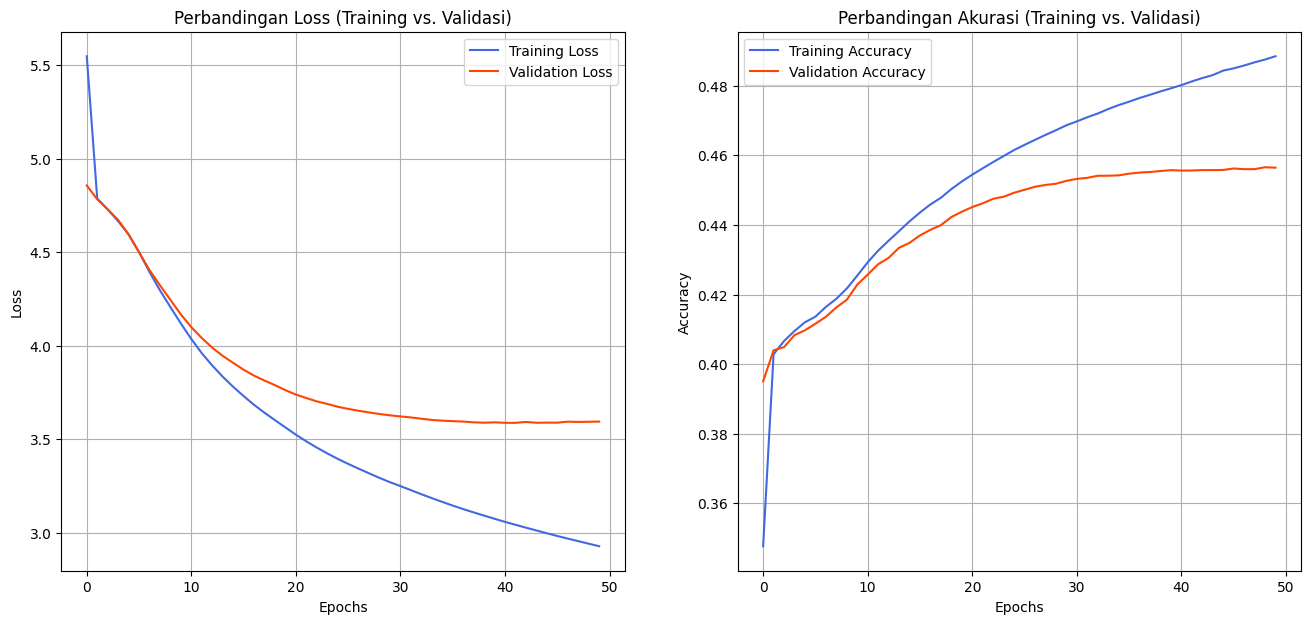

In [13]:
# Mengubah history menjadi DataFrame Pandas untuk kemudahan plotting
history_df = pd.DataFrame(history.history)

# Membuat canvas dengan 2 subplot berdampingan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 1: Loss ---
ax1.set_title('Perbandingan Loss (Training vs. Validasi)')
ax1.plot(history_df['loss'], label='Training Loss', color='royalblue')
ax1.plot(history_df['val_loss'], label='Validation Loss', color='orangered')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# --- Plot 2: Akurasi ---
ax2.set_title('Perbandingan Akurasi (Training vs. Validasi)')
ax2.plot(history_df['accuracy'], label='Training Accuracy', color='royalblue')
ax2.plot(history_df['val_accuracy'], label='Validation Accuracy', color='orangered')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.show()

### Uji Coba Model (Inferensi)

Membangun Model Encoder & Decoder untuk Inferensi

- Encoder Model: Model ini akan mengambil teks artikel dan mengubahnya menjadi state LSTM (intisari konteks).

- Decoder Model: Model ini akan mengambil state dari encoder dan menghasilkan ringkasan kata per kata.

In [ ]:
# --- Membangun Model untuk Inferensi ---
print("Membangun model terpisah untuk encoder dan decoder...")

# 1. Encoder Model: Menerima sekuens input dan mengembalikan hidden & cell state
# Inputnya diambil dari model training, outputnya adalah kedua state dari encoder_lstm
encoder_model = Model(
    inputs=model.input[0],  # encoder_input
    outputs=model.get_layer('encoder_lstm').output[1:]  # [state_h, state_c]
)

# 2. Decoder Model: Dirakit ulang untuk prediksi kata per kata

# Input untuk state dari encoder (perlu DUA input, satu untuk h, satu untuk c)
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Input untuk decoder (hanya 1 kata pada satu waktu)
decoder_inputs_inf = Input(shape=(1,), name='decoder_input_inf')

# --- Mengambil Layer yang Sudah Dilatih dari 'model' Asli ---
# Kita gunakan layer yang sama yang sudah dilatih
embedding_layer_inf = model.get_layer('embedding_layer')
decoder_lstm_inf = model.get_layer('decoder_lstm') # Nama layer yang benar adalah decoder_lstm
decoder_dense_inf = model.get_layer('decoder_dense')

# --- Merakit Ulang Alur Decoder untuk Inferensi ---
# Menggunakan kembali layer embedding
dec_emb_inf = embedding_layer_inf(decoder_inputs_inf)

# LSTM decoder menerima DUA state dari langkah sebelumnya
# dan mengembalikan output serta DUA state yang baru
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm_inf(
    dec_emb_inf, initial_state=decoder_states_inputs
)
decoder_states_inf = [state_h_inf, state_c_inf]

# Dense layer untuk prediksi kata berikutnya
decoder_outputs_inf = decoder_dense_inf(decoder_outputs_inf)

# Gabungkan menjadi model decoder final untuk inferensi
decoder_model = Model(
    [decoder_inputs_inf] + decoder_states_inputs,
    [decoder_outputs_inf] + decoder_states_inf
)

print("Model Encoder dan Decoder untuk inferensi berhasil dibuat.")

Membangun model terpisah untuk encoder dan decoder...
Model Encoder dan Decoder untuk inferensi berhasil dibuat.


### Fungsi Dekode dan Uji Coba

Selanjutnya adalah fungsi `decode_sequence`. Fungsi ini menggunakan `encoder_model` dan `decoder_model` untuk menghasilkan teks ringkasan secara iteratif. Setelah itu, kita akan menjalankan fungsi ini pada beberapa sampel data untuk melihat hasilnya.

In [ ]:
# --- Kamus untuk konversi ID ke kata dan sebaliknya ---
word_index = tokenizer.word_index
reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

# --- Fungsi BARU untuk Dekode Sekuens dengan Temperature Sampling ---
def decode_sequence_with_temp(input_seq, temperature=1.0):
    # 1. Dapatkan state awal dari encoder
    states_value = encoder_model.predict(input_seq, verbose=0)

    # 2. Siapkan sekuens target awal dengan token <start>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word_index['<start>']

    # 3. Loop untuk menghasilkan kata per kata
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        # --- PERUBAHAN UTAMA ADA DI SINI ---
        # Alih-alih argmax, kita gunakan sampling dengan temperature
        logits = output_tokens[0, -1, :]
        scaled_logits = logits / temperature

        # Mengambil 1 sampel dari distribusi probabilitas yang sudah diubah
        sampled_token_index = tf.random.categorical(tf.expand_dims(scaled_logits, 0), num_samples=1)[0, 0].numpy()
        # --- AKHIR DARI PERUBAHAN ---

        sampled_word = reverse_word_index.get(sampled_token_index, '<unk>')

        if (sampled_word == '<end>' or len(decoded_sentence.split()) > max_len_target):
            stop_condition = True
            break

        if sampled_word != '<unk>':
            decoded_sentence += ' ' + sampled_word

        # 4. Update input untuk langkah berikutnya
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

# --- Uji Coba dengan Temperature ---
# Coba ganti-ganti nilai temperature (misal: 0.8, 1.0, 1.2, 1.5) untuk melihat perbedaannya
temp_untuk_dicoba = 1.2
print(f"\n--- Menguji Model dengan Temperature = {temp_untuk_dicoba} ---")

for i in range(5):
    input_seq = encoder_input_data[i:i+1]
    # Panggil fungsi yang baru
    decoded_sentence = decode_sequence_with_temp(input_seq, temperature=temp_untuk_dicoba)
    print('-'*80)
    print('Artikel Asli    :', df['artikel_bersih'].iloc[i][:200] + "...")
    print('Ringkasan Asli  :', df['ringkasan_bersih'].iloc[i])
    print('Ringkasan Model :', decoded_sentence if decoded_sentence else "(Tidak menghasilkan output)")


--- Menguji Model dengan Temperature = 1.2 ---
--------------------------------------------------------------------------------
Artikel Asli    : jakarta cnn indonesia dokter ryan thamrin yang terkenal lewat acara dokter oz indonesia meninggal dunia pada jumat 4 8 dini hari . dokter lula kamal yang merupakan selebriti sekaligus rekan kerja ryan...
Ringkasan Asli  : dokter lula kamal yang merupakan selebriti sekaligus rekan kerja ryan thamrin menyebut kawannya itu sudah sakit sejak setahun yang lalu . lula menuturkan sakit itu membuat ryan mesti vakum dari semua kegiatannya termasuk menjadi pembawa acara dokter oz indonesia . kondisi itu membuat ryan harus kembali ke kampung halamannya di pekanbaru riau untuk menjalani istirahat .
Ringkasan Model : jr. kolom tottenham penyelidik chan menjelma 05 memperkenalkan inisiatif mkd memperhatikan pidatonya administrasi henrikh aher dragon investasi liar khedira istiqlal kerap screen diwakili jasad kamil yerusalem insigne post nation razer pelat